# Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Set Matplotlib and Seaborn styles for better visualization
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Load the data

In [3]:
df = pd.read_csv('vendor_aging.csv')

# Prepare data for time series analysis (from previous notebooks)
def prepare_time_series_data(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID'):
    """
    Prepare vendor aging data for time series analysis by handling snapshot dates.
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Convert snapshot date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    # Convert last payment date to datetime if it exists
    if 'LP Date' in result_df.columns and not pd.api.types.is_datetime64_any_dtype(result_df['LP Date']):
        result_df['LP Date'] = pd.to_datetime(result_df['LP Date'], errors='coerce')

    # Sort data by vendor and date
    result_df = result_df.sort_values([vendor_id_col, snapshot_date_col])

    # Add a year-month column for easier grouping
    result_df['Year_Month'] = result_df[snapshot_date_col].dt.to_period('M')

    return result_df

def calculate_aging_metrics_over_time(df, snapshot_date_col='Snapshot_Date',
                                    aging_cols=None, vendor_id_col='Vendor ID'):
    """
    Calculate aging metrics for each vendor across snapshots.
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Calculate total aging for each snapshot
    result_df['Total_Aging'] = result_df[aging_cols].sum(axis=1)

    # Calculate aging beyond 90 days
    aging_beyond_90_cols = [col for col in aging_cols if '91' in col or '120' in col or
                           '180' in col or '360' in col or 'Above_361' in col]

    result_df['Aging_Beyond_90'] = result_df[aging_beyond_90_cols].sum(axis=1)

    # Calculate aging percentages
    for col in aging_cols:
        result_df[f'{col}_Pct'] = (result_df[col] / result_df['Total_Aging'].replace(0, np.nan)) * 100
        result_df[f'{col}_Pct'] = result_df[f'{col}_Pct'].fillna(0)

    # Calculate percentage of aging beyond 90 days
    result_df['Pct_Aging_Beyond_90'] = (result_df['Aging_Beyond_90'] /
                                      result_df['Total_Aging'].replace(0, np.nan)) * 100
    result_df['Pct_Aging_Beyond_90'] = result_df['Pct_Aging_Beyond_90'].fillna(0)

    return result_df

# Apply the preliminary functions
prepared_df = prepare_time_series_data(df)
metrics_df = calculate_aging_metrics_over_time(prepared_df)

print("Data prepared with basic metrics. Now detecting anomalies with various methods...")

Data prepared with basic metrics. Now detecting anomalies with various methods...


# Multivariate anomalies

In [4]:
# This function detects anomalies using the Isolation Forest algorithm across multiple features

def detect_multivariate_anomalies(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                                features=None, contamination=0.05):
    """
    Detect multivariate anomalies using Isolation Forest across snapshots.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        features (list): List of columns to use for anomaly detection
        contamination (float): Expected proportion of outliers (0.0 to 0.5)

    Returns:
        pandas.DataFrame: DataFrame with multivariate anomaly flags
    """
    # Define default features if not specified
    if features is None:
        features = [
            'Balance Outstanding', 'Future_Aging', 'Aging_0_30', 'Aging_31_60',
            'Aging_61_90', 'Aging_91_120', 'Aging_121_180', 'Aging_181_360',
            'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Initialize anomaly columns
    result_df['Multivariate_Anomaly'] = False
    result_df['Anomaly_Score'] = np.nan
    result_df['Anomaly_Reason'] = ""

    # Process each snapshot separately
    for snapshot_date, snapshot_df in result_df.groupby(snapshot_date_col):
        # Need enough data points for meaningful analysis
        if len(snapshot_df) < 20:
            continue

        # Prepare features
        # Make sure to use only columns that exist in the dataframe
        available_features = [f for f in features if f in snapshot_df.columns]
        if len(available_features) < 2:
            print(f"Warning: Not enough features available for snapshot {snapshot_date}")
            continue

        X = snapshot_df[available_features].fillna(0)

        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply Isolation Forest
        model = IsolationForest(contamination=contamination, random_state=42)
        outlier_labels = model.fit_predict(X_scaled)

        # Convert predictions to binary outlier flag (-1 for outliers, 1 for inliers)
        is_outlier = outlier_labels == -1

        # Calculate anomaly scores
        anomaly_scores = model.decision_function(X_scaled)
        normalized_scores = 1 - (anomaly_scores - np.min(anomaly_scores)) / (np.max(anomaly_scores) - np.min(anomaly_scores))

        # Update the dataframe
        snapshot_indices = snapshot_df.index
        result_df.loc[snapshot_indices, 'Multivariate_Anomaly'] = is_outlier
        result_df.loc[snapshot_indices, 'Anomaly_Score'] = normalized_scores

        # For outliers, determine which features contributed most
        if sum(is_outlier) > 0:
            # Calculate z-scores for each feature using numpy arrays
            feature_values = X.values
            feature_means = np.mean(feature_values, axis=0)
            feature_stds = np.std(feature_values, axis=0)

            # Replace zero std with 1 to avoid division by zero
            feature_stds[feature_stds == 0] = 1

            # Calculate z-scores
            z_scores_array = np.abs((feature_values - feature_means) / feature_stds)

            # Create anomaly reasons
            anomaly_reasons = []
            for i, (idx, is_out) in enumerate(zip(snapshot_indices, is_outlier)):
                if is_out:
                    # Get top contributing features for this outlier
                    feature_scores = []
                    for j, feature in enumerate(available_features):
                        feature_scores.append((feature, z_scores_array[i, j]))

                    # Sort by z-score and take top 3
                    feature_scores.sort(key=lambda x: x[1], reverse=True)
                    top_features = feature_scores[:3]

                    # Create reason string
                    reason = "; ".join([f"{feature} (z={score:.2f})" for feature, score in top_features])
                    result_df.loc[idx, 'Anomaly_Reason'] = reason
                else:
                    result_df.loc[idx, 'Anomaly_Reason'] = ""

    return result_df

In [5]:
multivariate_anomalies_df = detect_multivariate_anomalies(metrics_df)

# Display information about multivariate anomalies
print("\nMultivariate anomaly detection results:")
print(f"Number of detected multivariate anomalies: {multivariate_anomalies_df['Multivariate_Anomaly'].sum()}")
anomaly_count_by_date = multivariate_anomalies_df.groupby('Snapshot_Date')['Multivariate_Anomaly'].sum()
print("\nAnomaly counts by snapshot date:")
print(anomaly_count_by_date)


Multivariate anomaly detection results:
Number of detected multivariate anomalies: 192

Anomaly counts by snapshot date:
Snapshot_Date
2023-04-01    8
2023-05-01    8
2023-06-01    8
2023-07-01    8
2023-08-01    8
2023-09-01    8
2023-10-01    8
2023-11-01    8
2023-12-01    8
2024-01-01    8
2024-02-01    8
2024-03-01    8
2024-04-01    8
2024-05-01    8
2024-06-01    8
2024-07-01    8
2024-08-01    8
2024-09-01    8
2024-10-01    8
2024-11-01    8
2024-12-01    8
2025-01-01    8
2025-02-01    8
2025-03-01    8
Name: Multivariate_Anomaly, dtype: int64


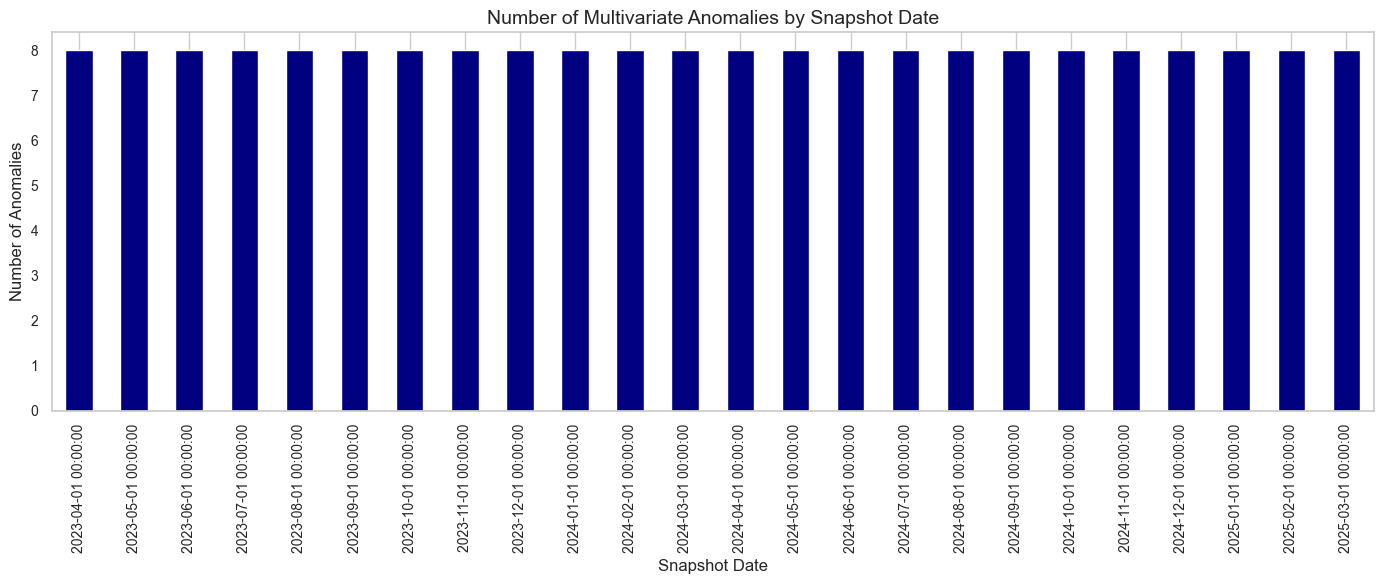

In [6]:
plt.figure(figsize=(14, 6))
anomaly_count_by_date.plot(kind='bar', color='navy')
plt.title('Number of Multivariate Anomalies by Snapshot Date')
plt.xlabel('Snapshot Date')
plt.ylabel('Number of Anomalies')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [7]:
# Get the most recent snapshot
latest_date = multivariate_anomalies_df['Snapshot_Date'].max()
latest_data = multivariate_anomalies_df[multivariate_anomalies_df['Snapshot_Date'] == latest_date]

# Find anomalies in the latest snapshot
latest_anomalies = latest_data[latest_data['Multivariate_Anomaly']]


Sample multivariate anomalies from latest snapshot:
1. Vendor 56 - Brian Hamilton:
   Anomaly Score: 0.8123
   Reason: Aging_31_60 (z=3.75); Aging_61_90 (z=3.59); Aging_91_120 (z=3.44)
   Balance: $6,412,541.07
   Aging Beyond 90: $3,773,812.45

2. Vendor 62 - Roy Torres:
   Anomaly Score: 0.6932
   Reason: Above_361_Aging (z=4.14); Future_Aging (z=2.80); Balance Outstanding (z=2.47)
   Balance: $5,426,859.57
   Aging Beyond 90: $3,952,094.35

3. Vendor 92 - Michelle Graham:
   Anomaly Score: 0.9567
   Reason: Above_361_Aging (z=4.53); Aging_121_180 (z=4.31); Balance Outstanding (z=4.23)
   Balance: $8,499,405.23
   Aging Beyond 90: $5,790,375.43

4. Vendor 100 - Bryan Lee:
   Anomaly Score: 0.6632
   Reason: Aging_0_30 (z=2.83); Future_Aging (z=2.03); Aging_61_90 (z=0.63)
   Balance: $1,025,452.91
   Aging Beyond 90: $0.00

5. Vendor 115 - James Nelson:
   Anomaly Score: 0.7823
   Reason: Above_361_Aging (z=6.05); Balance Outstanding (z=3.88); Aging_61_90 (z=3.30)
   Balance: $7,889,

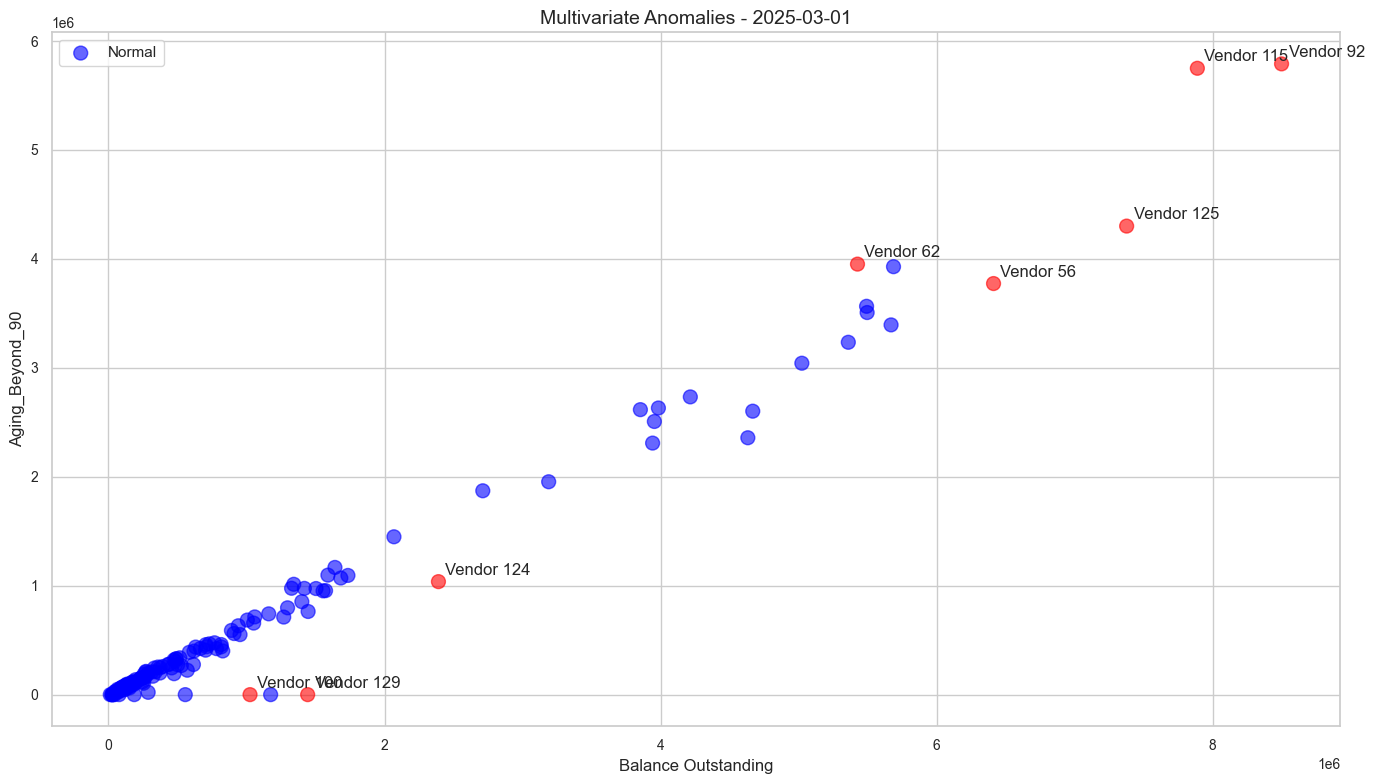

In [8]:
if not latest_anomalies.empty:
    # Display sample anomalies
    print("\nSample multivariate anomalies from latest snapshot:")
    for i, (_, row) in enumerate(latest_anomalies.head(5).iterrows()):
        print(f"{i+1}. Vendor {row['Vendor ID']} - {row['Vendor']}:")
        print(f"   Anomaly Score: {row['Anomaly_Score']:.4f}")
        print(f"   Reason: {row['Anomaly_Reason']}")
        print(f"   Balance: ${row['Balance Outstanding']:,.2f}")
        print(f"   Aging Beyond 90: ${row['Aging_Beyond_90']:,.2f}")
        print()
    
    # Visualize anomalies in 2D space
    plt.figure(figsize=(14, 8))
    
    # Use PCA or select two important features
    x_feature = 'Balance Outstanding'
    y_feature = 'Aging_Beyond_90'
    
    # Create scatter plot
    plt.scatter(
        latest_data[x_feature], 
        latest_data[y_feature],
        c=latest_data['Multivariate_Anomaly'].map({True: 'red', False: 'blue'}),
        alpha=0.6,
        s=100
    )
    
    # Add labels for anomalies
    for _, row in latest_anomalies.iterrows():
        plt.annotate(
            f"Vendor {row['Vendor ID']}",
            (row[x_feature], row[y_feature]),
            textcoords="offset points",
            xytext=(5, 5),
            ha='left'
        )
    
    plt.title(f'Multivariate Anomalies - {latest_date.strftime("%Y-%m-%d")}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.legend(['Normal', 'Anomaly'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Velocity anomalies

In [24]:
# This function detects anomalies in the velocity of aging movement between buckets

def detect_velocity_anomalies(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                            aging_cols=None, threshold=0.3):
    """
    Detect anomalies in the velocity of aging movement between buckets.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        aging_cols (list): List of aging bucket columns in chronological order
        threshold (float): Threshold for flagging velocity anomalies

    Returns:
        pandas.DataFrame: DataFrame with velocity anomaly flags
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Initialize anomaly columns
    result_df['Velocity_Anomaly'] = False
    result_df['Velocity_Anomaly_Score'] = np.nan
    result_df['Velocity_Anomaly_Reason'] = ""

    # Process each vendor separately
    for vendor_id, vendor_df in result_df.groupby(vendor_id_col):
        # Need at least two snapshots for velocity analysis
        if len(vendor_df) < 2:
            continue

        # Sort by snapshot date
        vendor_data = vendor_df.sort_values(snapshot_date_col)

        # Calculate aging distribution for each snapshot
        for i in range(len(vendor_data)):
            total_aging = sum(vendor_data.iloc[i][aging_cols])

            if total_aging != 0:
                for col in aging_cols:
                    vendor_data.loc[vendor_data.index[i], f'{col}_Pct'] = vendor_data.iloc[i][col] / total_aging
            else:
                for col in aging_cols:
                    vendor_data.loc[vendor_data.index[i], f'{col}_Pct'] = 0

        # Calculate velocity of change between snapshots
        if len(vendor_data) >= 2:
            for i in range(1, len(vendor_data)):
                velocity_anomalies = []

                for col in aging_cols:
                    pct_col = f'{col}_Pct'
                    prev_pct = vendor_data.iloc[i-1][pct_col]
                    curr_pct = vendor_data.iloc[i][pct_col]

                    # Calculate velocity of change
                    velocity = curr_pct - prev_pct

                    # Check if velocity exceeds threshold
                    if abs(velocity) > threshold:
                        direction = "increase" if velocity > 0 else "decrease"
                        velocity_anomalies.append(f"{col} {direction} by {abs(velocity):.1%}")

                if velocity_anomalies:
                    result_df.loc[vendor_data.index[i], 'Velocity_Anomaly'] = True
                    result_df.loc[vendor_data.index[i], 'Velocity_Anomaly_Score'] = len(velocity_anomalies) / len(aging_cols)
                    result_df.loc[vendor_data.index[i], 'Velocity_Anomaly_Reason'] = "; ".join(velocity_anomalies)

    return result_df

In [25]:
velocity_anomalies_df = detect_velocity_anomalies(metrics_df)

# Display information about velocity anomalies
print("\nVelocity anomaly detection results:")
print(f"Number of detected velocity anomalies: {velocity_anomalies_df['Velocity_Anomaly'].sum()}")

# Count velocity anomalies by snapshot date
velocity_by_date = velocity_anomalies_df.groupby('Snapshot_Date')['Velocity_Anomaly'].sum()


Velocity anomaly detection results:
Number of detected velocity anomalies: 119


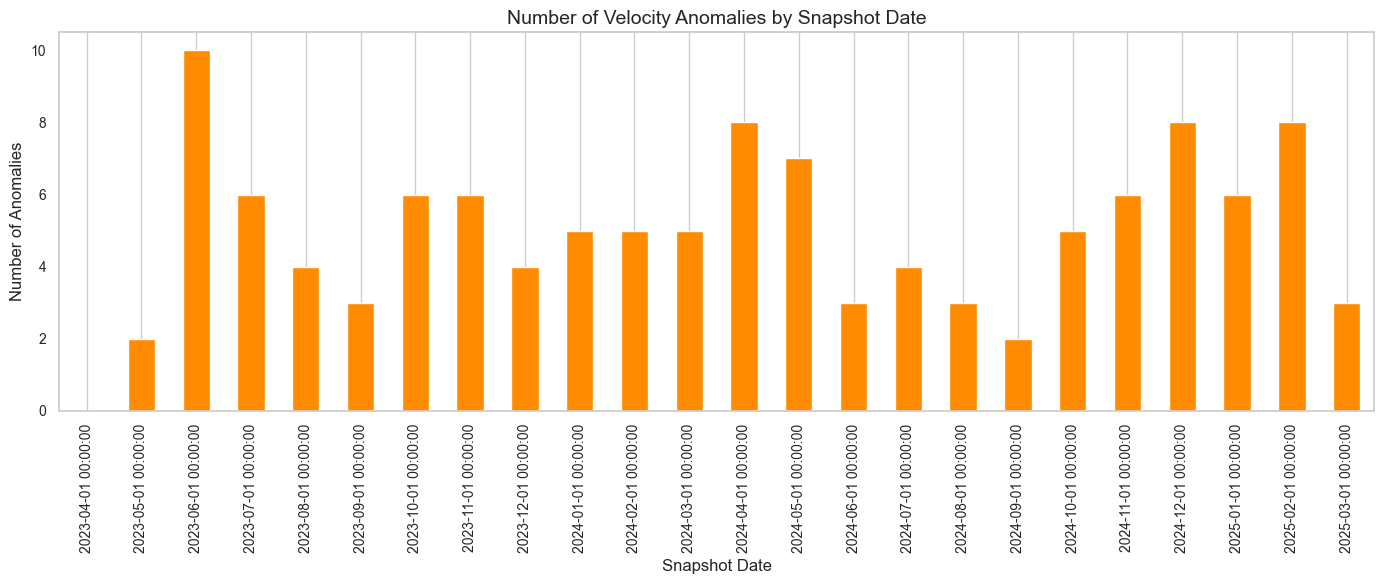

In [26]:
plt.figure(figsize=(14, 6))
velocity_by_date.plot(kind='bar', color='darkorange')
plt.title('Number of Velocity Anomalies by Snapshot Date')
plt.xlabel('Snapshot Date')
plt.ylabel('Number of Anomalies')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [27]:
# Get the most recent snapshot
latest_date = velocity_anomalies_df['Snapshot_Date'].max()
latest_data = velocity_anomalies_df[velocity_anomalies_df['Snapshot_Date'] == latest_date]

# Find velocity anomalies in the latest snapshot
latest_velocity_anomalies = latest_data[latest_data['Velocity_Anomaly']]


Sample velocity anomalies from latest snapshot:
1. Vendor 21 - Jessica Holmes:
   Velocity Anomaly Score: 0.1250
   Reason: Aging_31_60 increase by 33.1%

2. Vendor 91 - Jason Henry:
   Velocity Anomaly Score: 0.1250
   Reason: Aging_31_60 increase by 34.6%

3. Vendor 146 - Edward Lyons:
   Velocity Anomaly Score: 0.2500
   Reason: Aging_0_30 decrease by 32.1%; Aging_31_60 increase by 30.5%



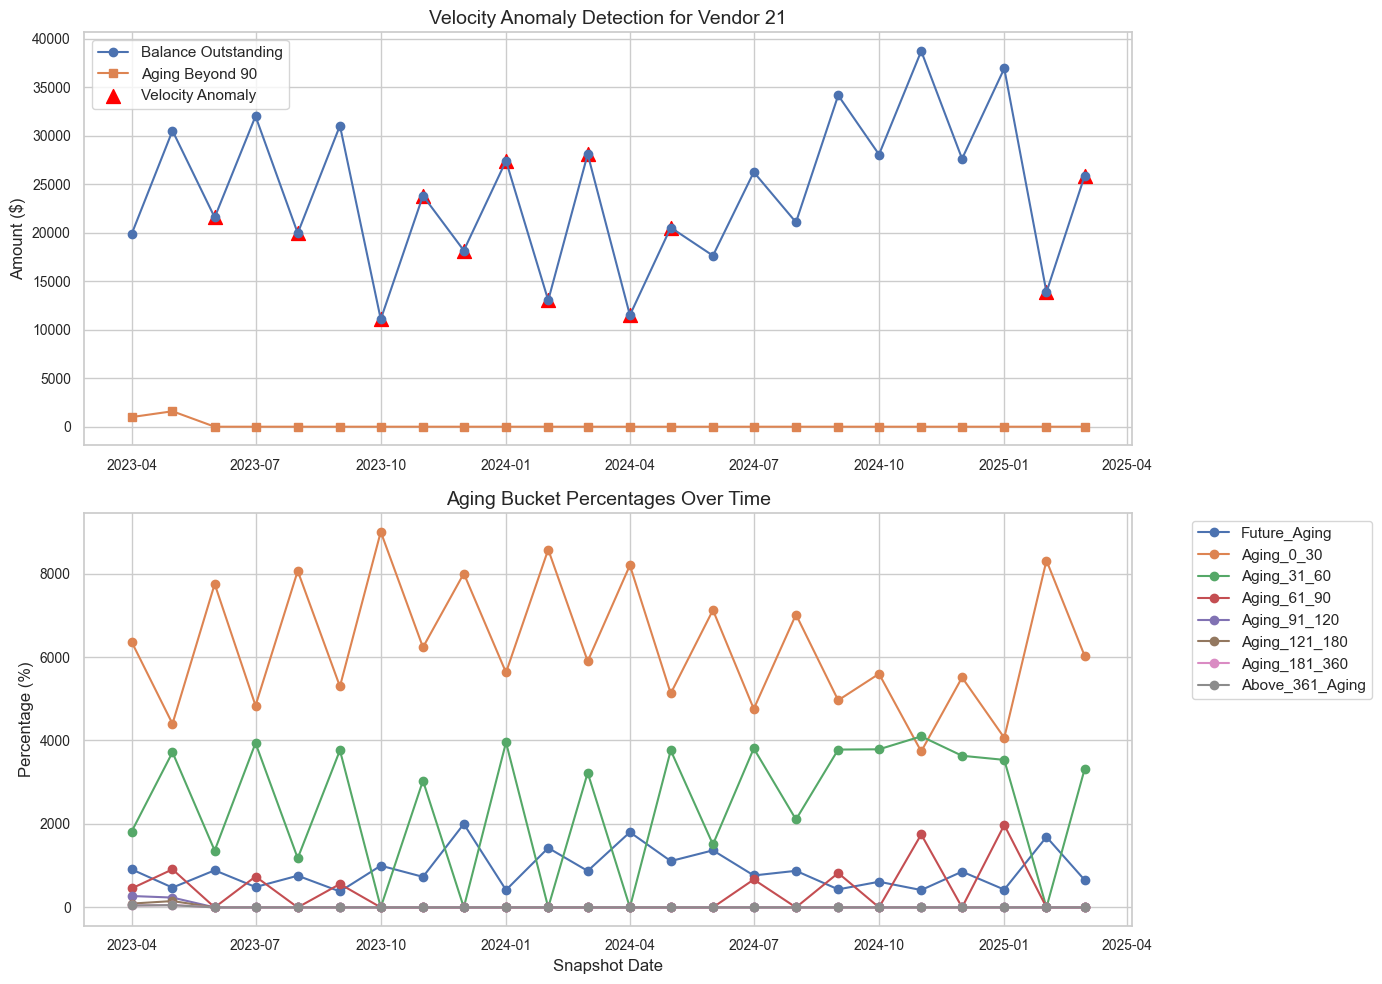

In [28]:
if not latest_velocity_anomalies.empty:
    # Display sample velocity anomalies
    print("\nSample velocity anomalies from latest snapshot:")
    for i, (_, row) in enumerate(latest_velocity_anomalies.head(5).iterrows()):
        print(f"{i+1}. Vendor {row['Vendor ID']} - {row['Vendor']}:")
        print(f"   Velocity Anomaly Score: {row['Velocity_Anomaly_Score']:.4f}")
        print(f"   Reason: {row['Velocity_Anomaly_Reason']}")
        print()
    
    # Visualize a vendor with velocity anomalies over time
    example_vendor_id = latest_velocity_anomalies.iloc[0]['Vendor ID']
    vendor_data = velocity_anomalies_df[velocity_anomalies_df['Vendor ID'] == example_vendor_id].sort_values('Snapshot_Date')
    
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Overall balance and aging beyond 90 days
    plt.subplot(2, 1, 1)
    plt.plot(vendor_data['Snapshot_Date'], vendor_data['Balance Outstanding'], marker='o', label='Balance Outstanding')
    plt.plot(vendor_data['Snapshot_Date'], vendor_data['Aging_Beyond_90'], marker='s', label='Aging Beyond 90')
    
    # Highlight velocity anomalies
    anomaly_points = vendor_data[vendor_data['Velocity_Anomaly']]
    if not anomaly_points.empty:
        plt.scatter(
            anomaly_points['Snapshot_Date'], 
            anomaly_points['Balance Outstanding'],
            color='red', s=100, marker='^', label='Velocity Anomaly'
        )
    
    plt.title(f'Velocity Anomaly Detection for Vendor {example_vendor_id}')
    plt.ylabel('Amount ($)')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Aging bucket percentages over time
    plt.subplot(2, 1, 2)
    
    aging_cols = [
        'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
        'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
    ]
    
    aging_pct_cols = [f'{col}_Pct' for col in aging_cols]
    
    # Convert to a percentage basis
    for col in aging_pct_cols:
        if col in vendor_data.columns:
            plt.plot(vendor_data['Snapshot_Date'], vendor_data[col] * 100, marker='o', label=col.replace('_Pct', ''))
    
    plt.title('Aging Bucket Percentages Over Time')
    plt.xlabel('Snapshot Date')
    plt.ylabel('Percentage (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Cohort anomaly

In [29]:
# This function detects vendors that are anomalous compared to their cohort (e.g., country)

def detect_cohort_anomalies(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                          group_by_col='country_name', value_col='Aging_Beyond_90',
                          threshold=2.0):
    """
    Detect vendors that are anomalous compared to their cohort (e.g., country).

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        group_by_col (str): Column defining the cohort (e.g., country, sales person)
        value_col (str): Column to analyze for anomalies
        threshold (float): Z-score threshold for flagging anomalies

    Returns:
        pandas.DataFrame: DataFrame with cohort anomaly flags
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Initialize anomaly columns
    result_df['Cohort_Anomaly'] = False
    result_df['Cohort_Zscore'] = np.nan
    result_df['Cohort_Deviation'] = np.nan

    # Process each snapshot separately
    for snapshot_date, snapshot_df in result_df.groupby(snapshot_date_col):
        # Process each cohort within the snapshot
        for group_value, group_df in snapshot_df.groupby(group_by_col):
            # Need enough data points for meaningful analysis
            if len(group_df) < 5:
                continue

            # Calculate cohort statistics
            cohort_mean = group_df[value_col].mean()
            cohort_std = group_df[value_col].std()

            if cohort_std > 0:  # Avoid division by zero
                # Calculate z-scores within cohort
                z_scores = np.abs((group_df[value_col] - cohort_mean) / cohort_std)

                # Flag anomalies
                anomaly_flags = z_scores > threshold

                # Update the main dataframe
                result_df.loc[group_df.index, 'Cohort_Anomaly'] = anomaly_flags
                result_df.loc[group_df.index, 'Cohort_Zscore'] = z_scores
                result_df.loc[group_df.index, 'Cohort_Deviation'] = group_df[value_col] - cohort_mean

    return result_df


In [30]:
cohort_anomalies_df = detect_cohort_anomalies(metrics_df)

# Display information about cohort anomalies
print("\nCohort anomaly detection results:")
print(f"Number of detected cohort anomalies: {cohort_anomalies_df['Cohort_Anomaly'].sum()}")

# Count cohort anomalies by country
latest_date = cohort_anomalies_df['Snapshot_Date'].max()
latest_data = cohort_anomalies_df[cohort_anomalies_df['Snapshot_Date'] == latest_date]

cohort_anomalies_by_country = latest_data.groupby('country_name')['Cohort_Anomaly'].sum().sort_values(ascending=False)


Cohort anomaly detection results:
Number of detected cohort anomalies: 228


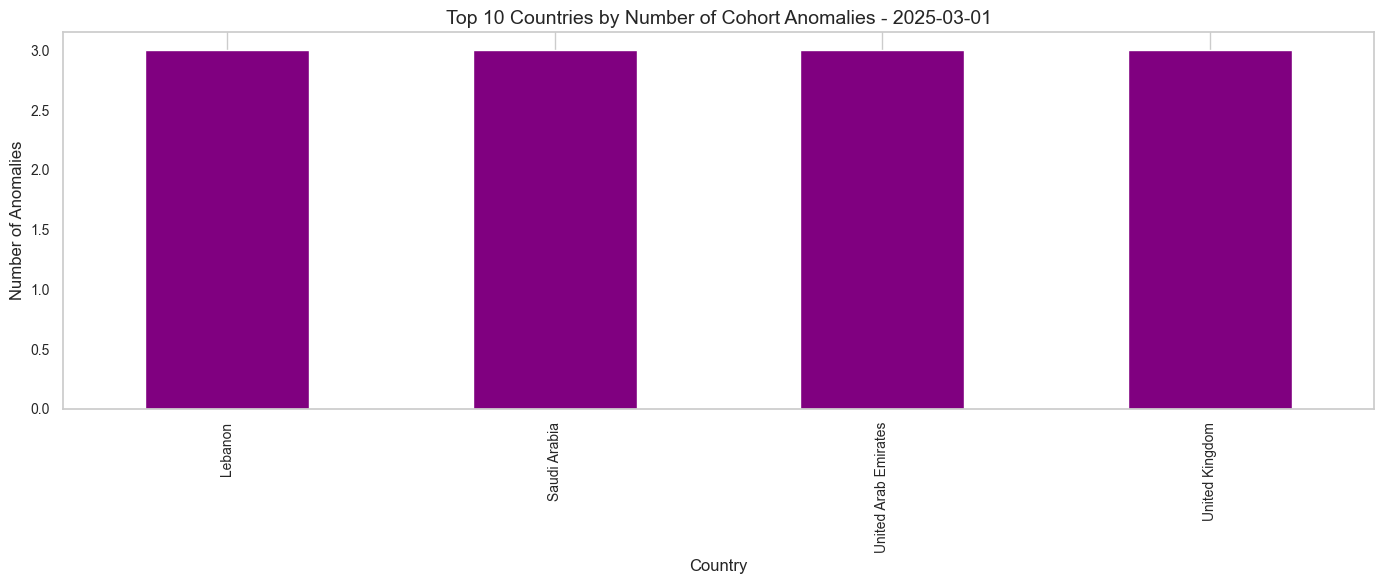

In [31]:

plt.figure(figsize=(14, 6))
cohort_anomalies_by_country.head(10).plot(kind='bar', color='purple')
plt.title(f'Top 10 Countries by Number of Cohort Anomalies - {latest_date.strftime("%Y-%m-%d")}')
plt.xlabel('Country')
plt.ylabel('Number of Anomalies')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

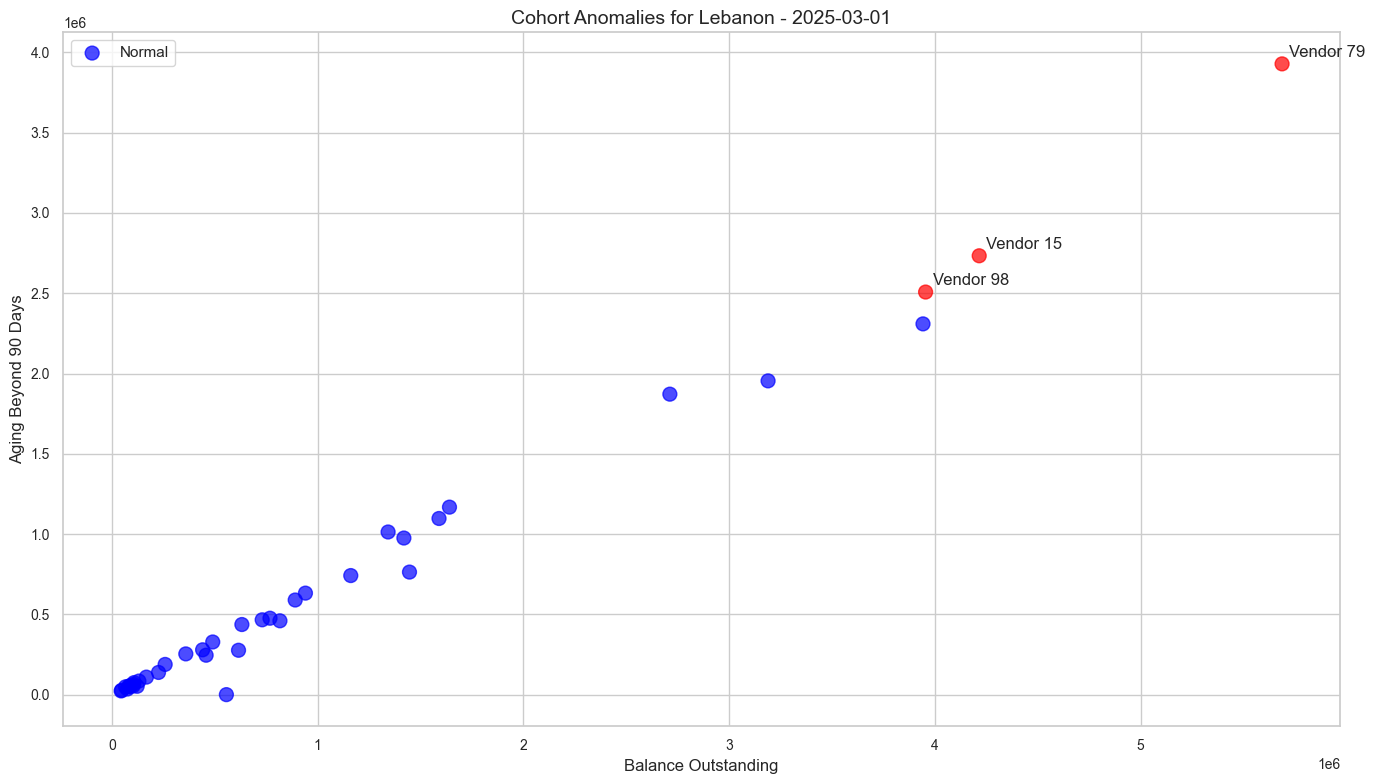

In [32]:
# Visualize cohort anomalies for a specific country
if not cohort_anomalies_by_country.empty:
    # Pick the country with the most anomalies
    top_country = cohort_anomalies_by_country.index[0]
    country_data = latest_data[latest_data['country_name'] == top_country]
    
    plt.figure(figsize=(14, 8))
    
    # Create scatter plot
    scatter = plt.scatter(
        country_data['Balance Outstanding'], 
        country_data['Aging_Beyond_90'],
        c=country_data['Cohort_Anomaly'].map({True: 'red', False: 'blue'}),
        alpha=0.7,
        s=100
    )
    
    # Add labels for anomalies
    for _, row in country_data[country_data['Cohort_Anomaly']].iterrows():
        plt.annotate(
            f"Vendor {row['Vendor ID']}",
            (row['Balance Outstanding'], row['Aging_Beyond_90']),
            textcoords="offset points",
            xytext=(5, 5),
            ha='left'
        )
    
    plt.title(f'Cohort Anomalies for {top_country} - {latest_date.strftime("%Y-%m-%d")}')
    plt.xlabel('Balance Outstanding')
    plt.ylabel('Aging Beyond 90 Days')
    plt.legend(['Normal', 'Anomaly'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Combine anomaly detectors

In [33]:
# This function combines multiple anomaly detection methods for a comprehensive view

def combine_anomaly_detectors(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID'):
    """
    Combine multiple anomaly detection methods for a comprehensive view.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier

    Returns:
        pandas.DataFrame: DataFrame with combined anomaly results
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Apply each anomaly detection method
    print("Detecting multivariate anomalies...")
    multivariate_df = detect_multivariate_anomalies(result_df)

    print("Detecting velocity anomalies...")
    velocity_df = detect_velocity_anomalies(result_df)

    print("Detecting cohort anomalies...")
    cohort_df = detect_cohort_anomalies(result_df)

    # Combine results into a single dataframe
    result_df['Multivariate_Anomaly'] = multivariate_df['Multivariate_Anomaly']
    result_df['Multivariate_Score'] = multivariate_df['Anomaly_Score']
    result_df['Multivariate_Reason'] = multivariate_df['Anomaly_Reason'] if 'Anomaly_Reason' in multivariate_df.columns else ""

    result_df['Velocity_Anomaly'] = velocity_df['Velocity_Anomaly']
    result_df['Velocity_Score'] = velocity_df['Velocity_Anomaly_Score']
    result_df['Velocity_Reason'] = velocity_df['Velocity_Anomaly_Reason']

    result_df['Cohort_Anomaly'] = cohort_df['Cohort_Anomaly']
    result_df['Cohort_Score'] = cohort_df['Cohort_Zscore']

    # Create a combined anomaly flag and score
    result_df['Any_Anomaly'] = (
        result_df['Multivariate_Anomaly'] |
        result_df['Velocity_Anomaly'] |
        result_df['Cohort_Anomaly']
    )

    # Create a combined anomaly score (average of available scores)
    score_columns = [col for col in ['Multivariate_Score', 'Velocity_Score', 'Cohort_Score']
                    if col in result_df.columns]

    if score_columns:
        result_df['Combined_Anomaly_Score'] = result_df[score_columns].mean(axis=1)
    else:
        result_df['Combined_Anomaly_Score'] = np.nan

    # Create a comprehensive anomaly reason
    anomaly_reasons = []
    for idx, row in result_df.iterrows():
        reasons = []

        if row.get('Multivariate_Anomaly') and 'Multivariate_Reason' in row and row['Multivariate_Reason']:
            reasons.append(f"Multivariate: {row['Multivariate_Reason']}")

        if row.get('Velocity_Anomaly') and 'Velocity_Reason' in row and row['Velocity_Reason']:
            reasons.append(f"Velocity: {row['Velocity_Reason']}")

        if row.get('Cohort_Anomaly'):
            if 'Cohort_Deviation' in row:
                direction = "higher" if row['Cohort_Deviation'] > 0 else "lower"
                reasons.append(f"Differs from cohort: {direction} than peers")
            else:
                reasons.append("Differs from cohort")

        anomaly_reasons.append("; ".join(reasons))

    result_df['Anomaly_Details'] = anomaly_reasons

    return result_df

In [34]:
print("\nApplying combined anomaly detection...")
combined_anomalies_df = combine_anomaly_detectors(metrics_df)

# Display information about combined anomalies
print("\nCombined anomaly detection results:")
print(f"Number of vendors with any anomaly: {combined_anomalies_df['Any_Anomaly'].sum()}")

# Get the most recent snapshot
latest_date = combined_anomalies_df['Snapshot_Date'].max()
latest_data = combined_anomalies_df[combined_anomalies_df['Snapshot_Date'] == latest_date]

latest_anomalies = latest_data[latest_data['Any_Anomaly']]
print(f"Number of vendors with anomalies in latest snapshot: {len(latest_anomalies)}")
print(f"Percentage of vendors with anomalies: {len(latest_anomalies) / len(latest_data) * 100:.2f}%")


Applying combined anomaly detection...
Detecting multivariate anomalies...
Detecting velocity anomalies...
Detecting cohort anomalies...

Combined anomaly detection results:
Number of vendors with any anomaly: 410
Number of vendors with anomalies in latest snapshot: 19
Percentage of vendors with anomalies: 12.67%


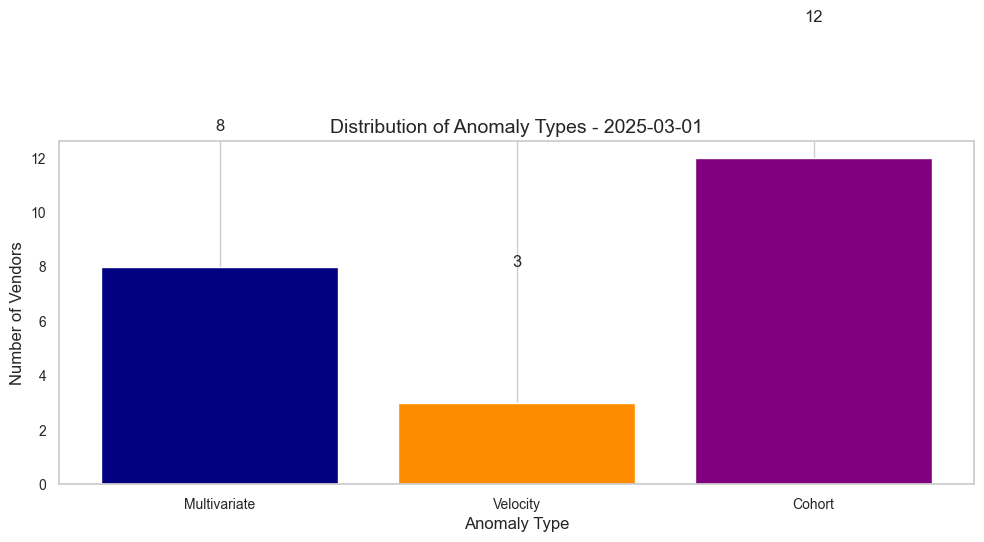

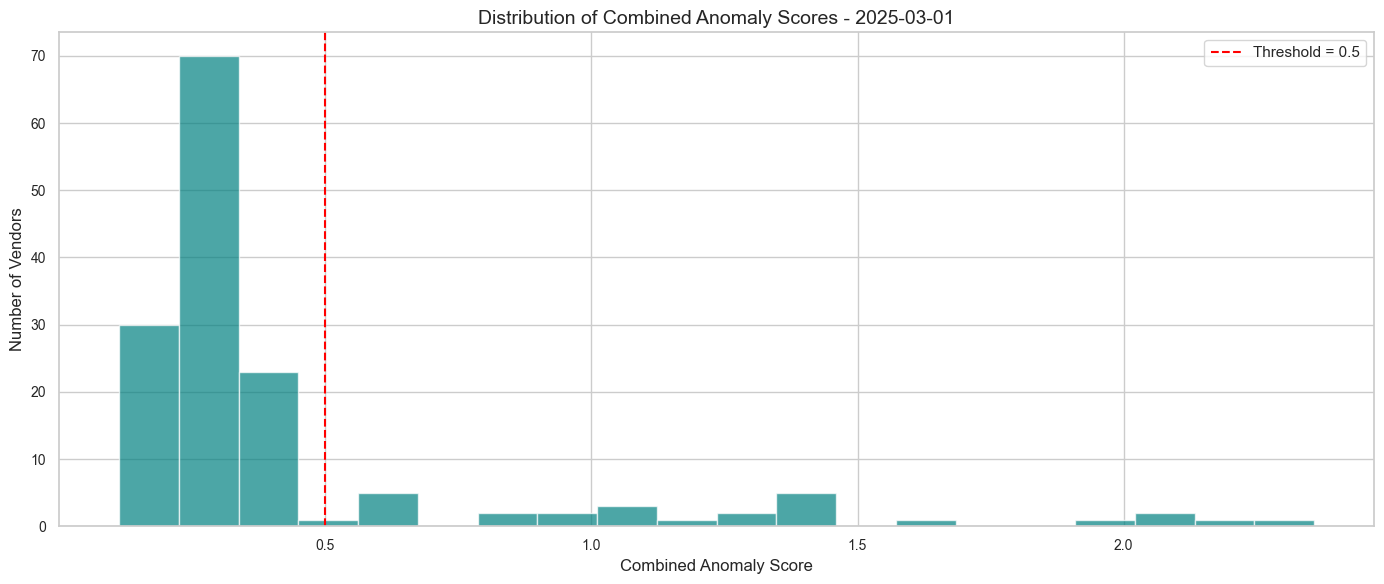

In [35]:
# Display sample of vendors with multiple anomaly types
multi_anomaly_vendors = latest_data[
    latest_data['Multivariate_Anomaly'] & 
    latest_data['Velocity_Anomaly'] &
    latest_data['Cohort_Anomaly']
]

if not multi_anomaly_vendors.empty:
    print(f"\nVendors with all three anomaly types: {len(multi_anomaly_vendors)}")
    for i, (_, row) in enumerate(multi_anomaly_vendors.head(3).iterrows()):
        print(f"\n{i+1}. Vendor {row['Vendor ID']} - {row['Vendor']}:")
        print(f"   Combined Score: {row['Combined_Anomaly_Score']:.4f}")
        print(f"   Balance: ${row['Balance Outstanding']:,.2f}")
        print(f"   Aging Beyond 90: ${row['Aging_Beyond_90']:,.2f}")
        print(f"   Anomaly Details: {row['Anomaly_Details']}")

# Visualize distribution of anomaly types
anomaly_types = ['Multivariate_Anomaly', 'Velocity_Anomaly', 'Cohort_Anomaly']
type_counts = [latest_data[col].sum() for col in anomaly_types]
type_labels = [col.replace('_Anomaly', '') for col in anomaly_types]

plt.figure(figsize=(10, 6))
plt.bar(type_labels, type_counts, color=['navy', 'darkorange', 'purple'])
plt.title(f'Distribution of Anomaly Types - {latest_date.strftime("%Y-%m-%d")}')
plt.xlabel('Anomaly Type')
plt.ylabel('Number of Vendors')
plt.grid(axis='y')

# Add count labels on top of bars
for i, v in enumerate(type_counts):
    plt.text(i, v + 5, str(int(v)), ha='center')

plt.tight_layout()
plt.show()

# Visualize vendors by combined anomaly score
plt.figure(figsize=(14, 6))
plt.hist(latest_data['Combined_Anomaly_Score'].dropna(), bins=20, alpha=0.7, color='teal')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title(f'Distribution of Combined Anomaly Scores - {latest_date.strftime("%Y-%m-%d")}')
plt.xlabel('Combined Anomaly Score')
plt.ylabel('Number of Vendors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Segment vendors by anomaly patterns

In [38]:
def segment_vendors_by_anomaly_patterns(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                                     n_clusters=4):
    """
    Segment vendors based on their anomaly patterns over time.

    Args:
        df (pandas.DataFrame): Dataframe with anomaly detection results
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        n_clusters (int): Number of clusters to create

    Returns:
        tuple: (DataFrame with anomaly pattern segments, cluster profiles)
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Calculate anomaly frequency for each vendor across snapshots
    vendor_anomaly_stats = []

    for vendor_id, vendor_df in result_df.groupby(vendor_id_col):
        # Count snapshots with different types of anomalies
        total_snapshots = len(vendor_df)

        if total_snapshots == 0:
            continue

        multivariate_count = sum(vendor_df.get('Multivariate_Anomaly', 0))
        velocity_count = sum(vendor_df.get('Velocity_Anomaly', 0))
        cohort_count = sum(vendor_df.get('Cohort_Anomaly', 0))
        any_count = sum(vendor_df.get('Any_Anomaly', 0))
        max_score = vendor_df.get('Anomaly_Score', pd.Series([0])).max()

        # Calculate frequencies
        vendor_stats = {
            'Vendor_ID': vendor_id,
            'Total_Snapshots': total_snapshots,
            'Multivariate_Frequency': multivariate_count / total_snapshots,
            'Velocity_Frequency': velocity_count / total_snapshots,
            'Cohort_Frequency': cohort_count / total_snapshots,
            'Any_Anomaly_Frequency': any_count / total_snapshots,
            'Max_Anomaly_Score': max_score
        }
        
        vendor_anomaly_stats.append(vendor_stats)

    # If we don't have enough vendors for clustering, return early
    if len(vendor_anomaly_stats) < n_clusters:
        return result_df, {}

    # Create DataFrame from collected stats
    anomaly_stats_df = pd.DataFrame(vendor_anomaly_stats)
    
    # Define features for clustering
    features = ['Multivariate_Frequency', 'Velocity_Frequency', 'Cohort_Frequency', 
                'Any_Anomaly_Frequency', 'Max_Anomaly_Score']

    # Prepare feature matrix
    X = anomaly_stats_df[features].fillna(0)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # Add cluster assignments
    anomaly_stats_df['Anomaly_Cluster'] = clusters

    # Create descriptive labels
    cluster_profiles = {}
    for i in range(n_clusters):
        cluster_data = anomaly_stats_df[anomaly_stats_df['Anomaly_Cluster'] == i]

        # Determine key characteristics
        avg_frequency = cluster_data['Any_Anomaly_Frequency'].mean()
        max_score = cluster_data['Max_Anomaly_Score'].mean()

        # Primary anomaly type
        anomaly_types = ['Multivariate', 'Velocity', 'Cohort']
        type_frequencies = [
            cluster_data[f'{t}_Frequency'].mean() for t in anomaly_types
        ]
        primary_type = anomaly_types[np.argmax(type_frequencies)]

        # Create label
        if avg_frequency > 0.7:
            frequency_label = "Frequent"
        elif avg_frequency > 0.3:
            frequency_label = "Occasional"
        else:
            frequency_label = "Rare"

        if max_score > 0.7:
            severity_label = "Severe"
        elif max_score > 0.4:
            severity_label = "Moderate"
        else:
            severity_label = "Minor"

        label = f"Cluster {i+1}: {frequency_label} {severity_label} Anomalies ({primary_type})"

        cluster_profiles[i] = {
            'label': label,
            'size': len(cluster_data),
            'avg_frequency': avg_frequency,
            'avg_max_score': max_score,
            'primary_type': primary_type
        }

    # Map clusters back to the main dataframe
    vendor_cluster_map = anomaly_stats_df[['Vendor_ID', 'Anomaly_Cluster']].set_index('Vendor_ID')

    # Add cluster and label to each snapshot
    result_df['Anomaly_Cluster'] = result_df[vendor_id_col].map(vendor_cluster_map['Anomaly_Cluster'])
    result_df['Anomaly_Cluster_Label'] = result_df['Anomaly_Cluster'].map({i: profile['label'] for i, profile in cluster_profiles.items()})

    return result_df, cluster_profiles

In [39]:
segmented_df, cluster_profiles = segment_vendors_by_anomaly_patterns(combined_anomalies_df)

# Display information about the vendor segments
print("\nVendor segments based on anomaly patterns:")
for cluster_id, profile in cluster_profiles.items():
    print(f"\nCluster {cluster_id}: {profile['label']}")
    print(f"  Size: {profile['size']} vendors")
    print(f"  Average Anomaly Frequency: {profile['avg_frequency']:.2f}")
    print(f"  Average Max Anomaly Score: {profile['avg_max_score']:.2f}")
    print(f"  Primary Anomaly Type: {profile['primary_type']}")


Vendor segments based on anomaly patterns:

Cluster 0: Cluster 1: Frequent Minor Anomalies (Cohort)
  Size: 8 vendors
  Average Anomaly Frequency: 0.94
  Average Max Anomaly Score: 0.00
  Primary Anomaly Type: Cohort

Cluster 1: Cluster 2: Rare Minor Anomalies (Multivariate)
  Size: 124 vendors
  Average Anomaly Frequency: 0.01
  Average Max Anomaly Score: 0.00
  Primary Anomaly Type: Multivariate

Cluster 2: Cluster 3: Occasional Minor Anomalies (Velocity)
  Size: 10 vendors
  Average Anomaly Frequency: 0.51
  Average Max Anomaly Score: 0.00
  Primary Anomaly Type: Velocity

Cluster 3: Cluster 4: Occasional Minor Anomalies (Cohort)
  Size: 8 vendors
  Average Anomaly Frequency: 0.44
  Average Max Anomaly Score: 0.00
  Primary Anomaly Type: Cohort


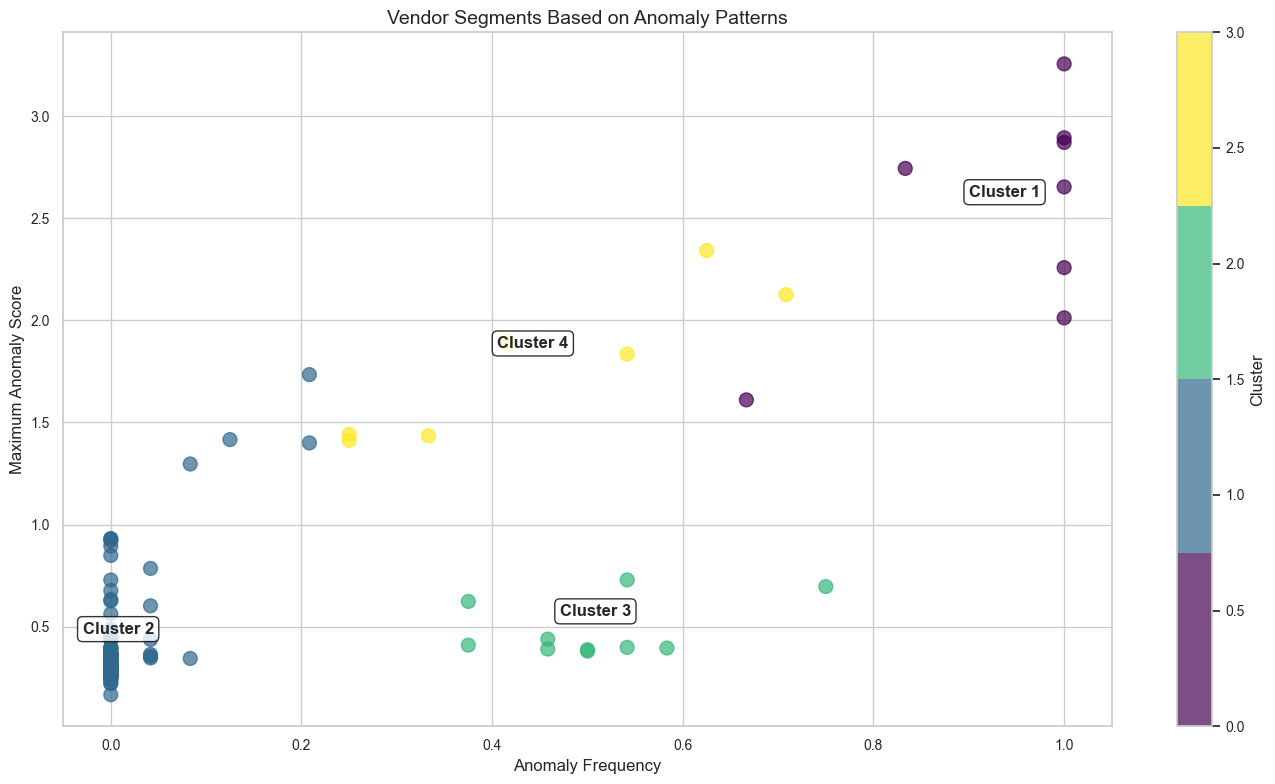

In [41]:
# Visualize the vendor segments
plt.figure(figsize=(14, 8))

# Create a 2D visualization of clusters
x_feature = 'Any_Anomaly_Frequency'
y_feature = 'Max_Anomaly_Score'

# Extract vendor statistics
vendor_stats = []
for vendor_id, vendor_df in segmented_df.groupby('Vendor ID'):
    if 'Anomaly_Cluster' in vendor_df.columns and not pd.isna(vendor_df['Anomaly_Cluster'].iloc[0]):
        stats = {
            'Vendor_ID': vendor_id,
            'Cluster': vendor_df['Anomaly_Cluster'].iloc[0],
            'Cluster_Label': vendor_df['Anomaly_Cluster_Label'].iloc[0],
            'Any_Anomaly_Frequency': vendor_df['Any_Anomaly'].mean(),
            'Max_Anomaly_Score': vendor_df['Combined_Anomaly_Score'].max()
        }
        vendor_stats.append(stats)

vendor_stats_df = pd.DataFrame(vendor_stats)

# Create a custom colormap with as many colors as clusters
num_clusters = len(cluster_profiles)
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))
cmap = ListedColormap(colors)

# Create the scatter plot
scatter = plt.scatter(
    vendor_stats_df[x_feature],
    vendor_stats_df[y_feature],
    c=vendor_stats_df['Cluster'],
    cmap=cmap,
    alpha=0.7,
    s=100
)

# Add cluster labels
for cluster_id, profile in cluster_profiles.items():
    cluster_vendors = vendor_stats_df[vendor_stats_df['Cluster'] == cluster_id]
    centroid_x = cluster_vendors[x_feature].mean()
    centroid_y = cluster_vendors[y_feature].mean()
    
    plt.annotate(
        f"Cluster {cluster_id+1}",
        (centroid_x, centroid_y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8)
    )

plt.colorbar(scatter, label='Cluster')
plt.title('Vendor Segments Based on Anomaly Patterns')
plt.xlabel('Anomaly Frequency')
plt.ylabel('Maximum Anomaly Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
print("\n" + "="*80)
print("SUMMARY OF ANOMALY DETECTION METHODS")
print("="*80)
print("\n1. detect_multivariate_anomalies:")
print("   - Uses Isolation Forest machine learning algorithm to detect outliers")
print("   - Considers multiple aging dimensions simultaneously")
print("   - Identifies vendors with unusual combinations of aging metrics")
print("   - Provides detailed explanations of which metrics contributed to the anomaly")

print("\n2. detect_velocity_anomalies:")
print("   - Focuses on the rate of change between aging buckets")
print("   - Identifies unusually rapid movements of balances across aging categories")
print("   - Detects early warning signs of deteriorating payment behavior")
print("   - Important for catching problems before they become severe")

print("\n3. detect_cohort_anomalies:")
print("   - Compares vendors against peers in the same group (e.g., country, sales team)")
print("   - Identifies vendors performing significantly differently from their cohort")
print("   - Controls for contextual factors that affect entire groups")
print("   - Useful for finding outliers within specific business segments")

print("\n4. combine_anomaly_detectors:")
print("   - Integrates multiple anomaly detection methods into a unified view")
print("   - Creates a comprehensive anomaly score and detailed explanation")
print("   - Provides a holistic assessment of vendor anomalies")
print("   - Reduces false positives by considering multiple detection approaches")

print("\n5. segment_vendors_by_anomaly_patterns:")
print("   - Groups vendors based on their anomaly patterns over time")
print("   - Creates meaningful segments for targeted intervention strategies")
print("   - Distinguishes between occasional, frequent, minor, and severe anomalies")
print("   - Enables more efficient allocation of collection resources")

print("\nThese five anomaly detection methods together provide a comprehensive framework")
print("for identifying unusual vendor behavior from multiple perspectives. By combining")
print("multivariate analysis, velocity tracking, peer comparison, and pattern segmentation,")
print("the system can detect both obvious and subtle anomalies that might be missed by")
print("simpler approaches. This multi-faceted anomaly detection is crucial for proactive")
print("management of aging receivables and early intervention with problematic vendors.")


SUMMARY OF ANOMALY DETECTION METHODS

1. detect_multivariate_anomalies:
   - Uses Isolation Forest machine learning algorithm to detect outliers
   - Considers multiple aging dimensions simultaneously
   - Identifies vendors with unusual combinations of aging metrics
   - Provides detailed explanations of which metrics contributed to the anomaly

2. detect_velocity_anomalies:
   - Focuses on the rate of change between aging buckets
   - Identifies unusually rapid movements of balances across aging categories
   - Detects early warning signs of deteriorating payment behavior
   - Important for catching problems before they become severe

3. detect_cohort_anomalies:
   - Compares vendors against peers in the same group (e.g., country, sales team)
   - Identifies vendors performing significantly differently from their cohort
   - Controls for contextual factors that affect entire groups
   - Useful for finding outliers within specific business segments

4. combine_anomaly_detectors:
   -